# Model Performance Analysis

In [2]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import os 
# for some models GPU capacity was not enough hence trained those models by disabling GPU with below line
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from tensorflow.keras.layers import Dense,Flatten,Embedding,Concatenate
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Input,Activation,LSTM,BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale,MinMaxScaler
import tensorflow_text as text
import pathlib
import seaborn as sns
import tensorflow_addons as tfa

## Reading the stored data

In [3]:
# reading preprocessed data

structured_data = pickle.load(open("structured_data.pkl","rb"))
print("Shape of created dataframe is : ",structured_data.shape)
print("Shape of created featrure matrix in feat_mat column is : ",structured_data['feat_mat'].values[1].shape)

Shape of created dataframe is :  (10956, 6)
Shape of created featrure matrix in feat_mat column is :  (500, 310, 1)


In [4]:
# for missing data for any company, on a particular day, was assigned 0 as sign change label
# hence removing those to have cleaned data
#structured_data = structured_data[structured_data.sign_change != 0]


# changing -1 & 1 to 0 & 1 to have binary crossentropy as loss and sigmoid as final layer activation.
#structured_data['sign_change'] = structured_data.sign_change.apply(lambda x:0 if x==-1 else 1)

structured_data = structured_data.sort_values(by=['post_date','company_name'])

structured_data['tweet_text_len'] = structured_data.tweet_text.apply(lambda x:len(x.split()))

structured_data.head()

,post_date,tweet_text,company_name,feat_mat,change_label,sign_change,tweet_text_len
0,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AAPL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
1826,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AMZN,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
9130,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,GOOG,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
3652,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,GOOGL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
7304,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,MSFT,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501


### Since the data split is being done on temporal basis, there is no randomness in train test split. Hence we will get exactly same train and validation sets that we trained our models on.

In [5]:
# the data that we have is from '2015-01-01' to '2019-12-31'
# Hence taking last 6 months as test data and 4 years, 6 months of training data from the dataset
train_data = structured_data[structured_data.post_date < '2019-06-01']
test_data = structured_data[structured_data.post_date >= '2019-06-01']


# getting train data for all models
# two class labels are there, one is magnitude of % change
# while second one is sign of change (values 0 or 1 : 0 - negative change, 1 - positive change)
y_train_change = train_data['change_label'].values
y_train_sign = train_data['sign_change'].values
y_train_sign = y_train_sign.astype('int')
x_train_text = train_data['tweet_text'].values
'''x_train_tweet_vec = train_data['tweet_vec'].values
x_train_tweet_vec = list(x_train_tweet_vec)
x_train_tweet_vec = np.array(x_train_tweet_vec)'''
x_train_feat = list(train_data['feat_mat'].values)
x_train_feat = np.array(x_train_feat)
x_train_company = train_data['company_name'].values

# getting test data for all models
y_test_change = test_data['change_label'].values
y_test_sign = test_data['sign_change'].values
y_test_sign = y_test_sign.astype('int')
x_test_text = test_data['tweet_text'].values
'''x_test_tweet_vec = test_data['tweet_vec'].values
x_test_tweet_vec = list(x_test_tweet_vec)
x_test_tweet_vec = np.array(x_test_tweet_vec)'''
x_test_feat = list(test_data['feat_mat'].values)
x_test_feat = np.array(x_test_feat)
x_test_company = test_data['company_name'].values

print("Number of data points in train data are :",train_data.shape[0])
print("Number of data points in train data are :",test_data.shape[0])

Number of data points in train data are : 9672
Number of data points in train data are : 1284


### Tokenizing tweet text with  BertTokenizer and Company name Column with simple Tokenizer

In [6]:
# referred below link to implement subword tokenizer
# https://www.tensorflow.org/text/guide/subwords_tokenizer

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=[]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

# creating BertTokenizer object with vocab text file genrated as per reference link stated above
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)
vocab_size_text = len(pathlib.Path('en_vocab.txt').read_text().splitlines())+ 1


# Using BertTokenizer to tokenize train data
encoded_text = en_tokenizer.tokenize(x_train_text)
encoded_text = encoded_text.merge_dims(-2,-1)   # reducing dimension of ragged tensor
encoded_text = encoded_text.to_list()           # converting to list to pad the sequences
max_length = 5000                               # max length of padding
train_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')


# Using BertTokenizer to tokenize test data 
encoded_text = en_tokenizer.tokenize(x_test_text)
encoded_text = encoded_text.merge_dims(-2,-1)
encoded_text = encoded_text.to_list()
test_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')

pickle.dump([vocab_size_text,train_text,test_text],open("bert_tokens.pkl","wb"))

In [7]:
[vocab_size_text,train_text,test_text] = pickle.load(open("bert_tokens.pkl","rb"))

In [8]:
# We don't need to use subwordtokenizer here since these company names are standard
# and these will not be changed while giving as inputs


# creating tokens for company names
tokenizer = Tokenizer()                   # creating tokenizer object
tokenizer.fit_on_texts(x_train_company) 
vocab_size_company = len(tokenizer.word_index) + 1

# getting tokenized train data
train_comp = np.array(tokenizer.texts_to_sequences(x_train_company))

# getting tokenized test data
test_comp = np.array(tokenizer.texts_to_sequences(x_test_company))

## Trained Model Summary

<table>
    <tr>
        <td><b> Sr. No. </b> </td>
        <td><b>Model</b></td>
        <td><b>Inputs</b></td>
        <td><b>Outputs</b></td>
        <td><b>Min val_change_prediction loss</b></td>
        <td><b>Min val_sign_prediction loss</b></td>
        <td><b>Mean deviation from actual values</b></td>
        <td><b>Correct signs predicted out of 1282</b></td>
    </tr>
    <tr>
        <td>1. </td>
        <td>Base model trained with just Feature Matrix</td>
        <td>input_feat,input_company</td>
        <td>output_change, output_sign</td>
        <td>1.5024</td>
        <td>0.6096</td>
        <td>0.75145924</td>
        <td>866</td>
    </tr>
    <tr>
        <td>2. </td>
        <td>Model trained with just Combined Tweet Text Data</td>
        <td> input_text,input_company </td>
        <td>output_change, output_sign</td>
        <td> 1.4636</td>
        <td>0.6525</td>
        <td>0.7918114</td>
        <td>782</td>
    </tr>
    <tr>
        <td>3. </td>
        <td>Model trained with Both Tweet text and Feature Matrix</td>
        <td> input_text,input_feat,input_company </td>
        <td>output_change, output_sign</td>
        <td>1.5635 </td>
        <td>0.6344</td>
        <td>0.86987495</td>
        <td>872</td>
    </tr>
    <tr>
        <td>4. </td>
        <td>Multichannel Convolution Neural Network Model with both tweet text and feature matrix</td>
        <td> input_text,input_feat,input_company </td>
        <td>output_change, output_sign</td>
        <td> 1.5560 </td>
        <td>0.6288</td>
        <td>0.85519534</td>
        <td>900</td>
    </tr>
    <tr>
        <td>5. </td>
        <td>Multichannel Convolution Neural Network Model with just tweet text</td>
        <td> input_text,input_feat,input_company </td>
        <td>output_change, output_sign</td>
        <td> 1.4964  </td>
        <td> 0.6621 </td>
        <td> 0.80678344 </td>
        <td> 765 </td>
    </tr>
</table>

<li> With reference to the table stated above, we can observe that models with just tweet text as inputs are performing better when compared to just feature matrix input when we consider "val_change_prediction" loss. While models with just feature matrix as inputs are performing better with respect to sign prediction. Hence we can observe if we combine both text input and feature matrix in model 3 & 4 then we are able to get low "val_change_prediction" loss. </li>
<li> The mean deviation is the mean of deviation from actual % change values. This was having least value for model 3 with both text as input and feature matrix as input. </li>
<li> But if we consider both mean deviation and sign predictions, then Multichannel CNNs i.e. model 4 is performing better. Hence this can be considered as the best performing model. </li>
<li> Let us analyze where this model is performing better and where it's not. We will use saved model weights for prediction. </li>

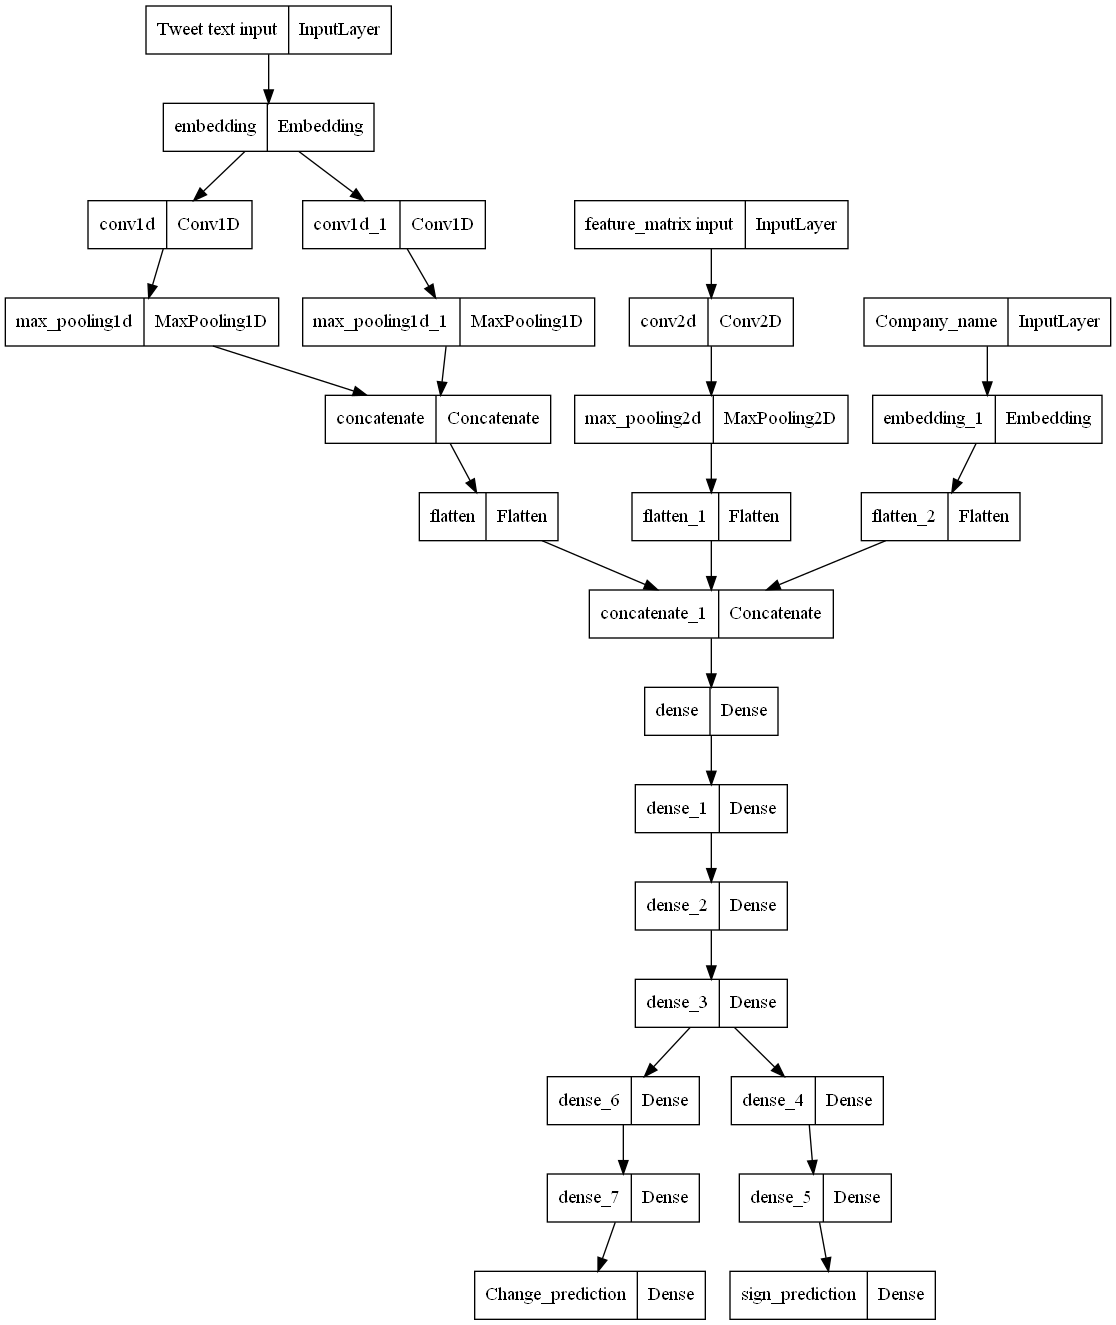

In [9]:
# defining model

np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(7011, 100)(input_text)


conv11 = Conv1D(64,kernel_size = 20,padding='same')(embedding_text)

maxpool11 = MaxPooling1D(10)(conv11)


conv12 = Conv1D(64,kernel_size = 10,padding='same')(embedding_text)

maxpool12 = MaxPooling1D(10)(conv12)


concat1 = Concatenate()([maxpool11,maxpool12])

flatten1 = Flatten()(concat1)



input_feat = Input(shape=(500,310,1),name="feature_matrix input")

conv21 = Conv2D(64,(3,3),padding='same')(input_feat)

pool21 = MaxPooling2D()(conv21)

flatten2 = Flatten()(pool21)



input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten3 = Flatten()(embedding_company)



concat = Concatenate()([flatten1,flatten2,flatten3])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer3 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer4 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer3)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_feat,input_company]
              ,outputs=[output_change,output_sign])


# Referred and implemented Piece wise Decay using below link
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay


step = tf.Variable(0, trainable=False)   # Variable to store and get step number in training

# some numbers are multiples of 301 cause these are steps per epoch with batch size 32
boundaries = [10,50,100, 602, 903]
values = [1e-6,1e-5, 1e-4, 1e-4, 0.5e-4, 1e-5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learn_rate = learning_rate_fn(step)


adamw_opt = tfa.optimizers.AdamW(learning_rate=learn_rate,weight_decay=0.0001)


# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=adamw_opt,
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model)

In [10]:
# Loading trained model weights with best overall error

model.load_weights('model4_save\weights-05-2.1848.hdf5')

In [11]:
prediction = model.predict([test_text,x_test_feat,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))

Mean Deviation for % change in closing prices is :  0.8547028
Number of correct signs predicted out of 1284 are : 888


### Performance Analysis

### 1. Analyzing w.r.t. Change_value_prediction

<li> Let us first analyze the percentile values for deviation from actual values. </li>

In [12]:
deviation = np.array(deviation)

for i in range(0,100,10):
    print("{}th percentile value for deviation is : {}".format(i,np.percentile(deviation,i)))

0th percentile value for deviation is : 0.0010419487953186035
10th percentile value for deviation is : 0.2096416711807251
20th percentile value for deviation is : 0.3853854894638062
30th percentile value for deviation is : 0.49443370699882505
40th percentile value for deviation is : 0.6274663209915163
50th percentile value for deviation is : 0.7301881015300751
60th percentile value for deviation is : 0.8136021852493285
70th percentile value for deviation is : 0.9849782645702362
80th percentile value for deviation is : 1.1403528213500977
90th percentile value for deviation is : 1.3933659672737126


<li> Based on the percentile values, let us set a threshold as follows: </li>
<table>
    <tr> 
        <td><b>Category</b></td>
        <td><b>Deviation Value</b></td>
    </tr>
    <tr>
        <td> Best </td>
        <td> <= 0.50 </td>
    </tr>
    <tr>
        <td> Medium </td>
        <td> 0.5 > & <= 1.0  </td>
    </tr>
    <tr>
        <td> Worst </td>
        <td> >= 1.0 </td>
    </tr>
</table>

In [14]:
best_indices = []  # empty list to store best prediction indices in test data
medium_indices = []  # empty list to store medium prediction indices in test data
worst_indices = []  # empty list to store worst prediction indices in test data

# Loop to iterate over all deviations and getting all indices
for i in range(len(deviation)):
    temp = deviation[i]
    if temp <= 0.5:
        best_indices.append(i)
    elif temp > 0.5 and temp <= 1:
        medium_indices.append(i)
    else:
        worst_indices.append(i)
        
best_indices = np.array(best_indices)
medium_indices = np.array(medium_indices)
worst_indices = np.array(worst_indices)

best_points = test_data.iloc[best_indices]
medium_points = test_data.iloc[medium_indices]
worst_points = test_data.iloc[worst_indices]

### 1.1 company_name Analysis

In [15]:
print("Number of predictions per Company in best points are : \n",best_points['company_name'].value_counts(),"\n\n")
print("Number of predictions per Company in medium points are : \n",medium_points['company_name'].value_counts(),"\n\n")
print("Number of predictions per Company in worst points are : \n",worst_points['company_name'].value_counts(),"\n\n")

Number of predictions per Company in best points are : 
 GOOG     70
AMZN     69
GOOGL    67
AAPL     66
MSFT     60
TSLA     57
Name: company_name, dtype: int64 


Number of predictions per Company in medium points are : 
 AMZN     94
AAPL     92
GOOGL    89
MSFT     88
GOOG     81
TSLA     81
Name: company_name, dtype: int64 


Number of predictions per Company in worst points are : 
 TSLA     76
MSFT     66
GOOG     63
GOOGL    58
AAPL     56
AMZN     51
Name: company_name, dtype: int64 




<li> We can observe that the number distribution is almost similar for companies except for AMZN and TSLA. </li>
<li> AMZN has highest points in best prediction while lowest points in worst predictions. </li>
<li> Similarly, TSLA has the highest points in worst predictions while lower number of points in best and medium predictions. </li>
<li> This means that model is performing better for AMZN while slightly less efficient for TSLA and almost similar for other companies. </li>

### 1.2 post_date Analysis

In [16]:
print("best_points start from date {} and end on date {}".format(best_points['post_date'].values[0],best_points['post_date'].values[-1]))
print("medium_points start from date {} and end on date {}".format(medium_points['post_date'].values[0],medium_points['post_date'].values[-1]))
print("worst_points start from date {} and end on date {}".format(worst_points['post_date'].values[0],worst_points['post_date'].values[-1]))

best_points start from date 2019-06-01 and end on date 2019-12-31
medium_points start from date 2019-06-02 and end on date 2019-12-30
worst_points start from date 2019-06-03 and end on date 2019-12-31


<li> Hence, points in all categories are distributed almost complete duration. </li>
<li> Let us analyze this in more detail. </li>

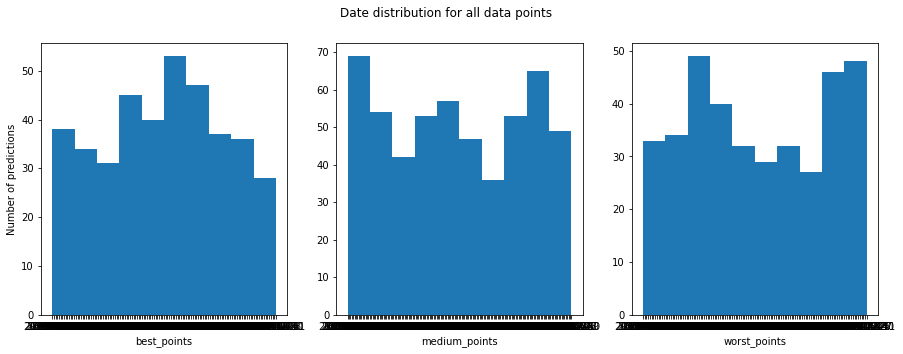

In [17]:
# Plotting date histogram
fig = plt.figure(figsize=(15,5))
fig.suptitle("Date distribution for all data points")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_points['post_date'].values)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2)
ax2.hist(medium_points['post_date'].values)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3)
ax3.hist(worst_points['post_date'].values)
plt.xlabel("worst_points")

plt.show()

<li> With above plots, we can state that number of predictions according to dates are almost similar but for worst points, there are fewer prediction points in mid of June since test data points start from 01-06-2019. </li>

### 1.3 tweet_text Analysis

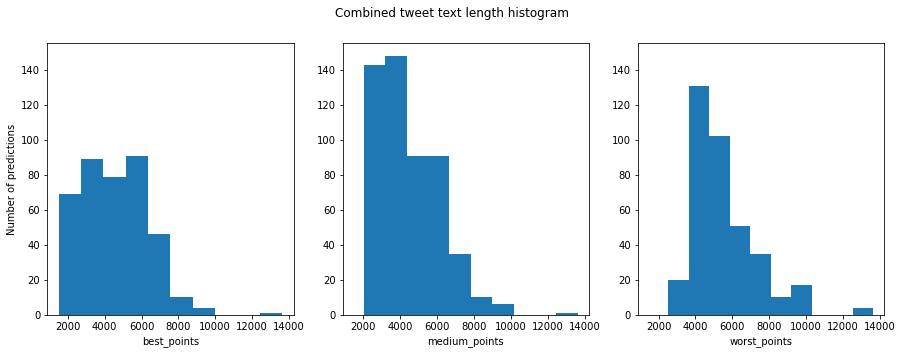

In [18]:
# getting lengths of all combined tweet text data

fig = plt.figure(figsize=(15,5))
fig.suptitle("Combined tweet text length histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist([len(i.split()) for i in best_points['tweet_text'].values])
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist([len(i.split()) for i in medium_points['tweet_text'].values])
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist([len(i.split()) for i in worst_points['tweet_text'].values])
plt.xlabel("worst_points")

plt.show()

<li> We can observe that the number of data points in all cases are lesser for lower lengths since there aren't many texts with high lenghts. </li>
<li> Also, for lengths lengths lesser than 2000, we are getting best predictions. Below apporx 3000 length, the predictions are best or medium. </li>
<li> With text lengths 6000 to 7000, the number of best predictions are more. And beyond 10,000 length, the predictions are worst. </li>

In [19]:
print(structured_data.shape)
print(train_data.shape)
print(test_data.shape)

(10956, 7)
(9672, 7)
(1284, 7)


In [20]:
print("Number of point in complete data with tweet text length > 8000 are : ",
      len(structured_data[structured_data.tweet_text_len >= 8000].values))
print("Number of point in train data with tweet text length > 8000 are : ",
      len(train_data[train_data.tweet_text_len >= 8000].values))
print("Number of point in train data with tweet text length > 8000 are : ",
      len(test_data[test_data.tweet_text_len >= 8000].values))

Number of point in complete data with tweet text length > 8000 are :  162
Number of point in train data with tweet text length > 8000 are :  102
Number of point in train data with tweet text length > 8000 are :  60


### 1.4 change_label Analysis

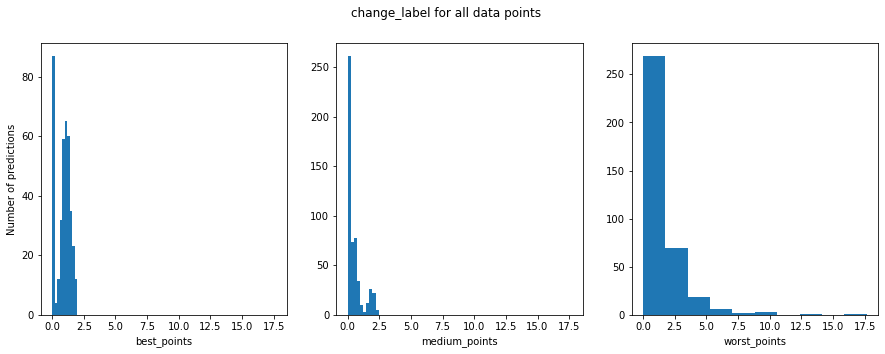

In [21]:
# Plotting date histogram
fig = plt.figure(figsize=(15,5))
fig.suptitle("change_label for all data points")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_points['change_label'].values)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1)
ax2.hist(medium_points['change_label'].values)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1)
ax3.hist(worst_points['change_label'].values)
plt.xlabel("worst_points")

plt.show()

<li> We can observe that, if the % change is beyond 2.5%, then the predictions are worse. </li>
<li> Also we can observe that that for lower deviation, best and medium points combined are more companred to worst predictions. </li>
<li> It can be concluded that if % change is more, then that change is driven by some major factors other than tweeter and thus the model is performing worst. </li>

### 1.5 sign_change Analysis

#### <li> Here 0 means negative change while 1 means positive change. </li>

In [22]:
print("Number of predictions per Company in best points are : \n",best_points['sign_change'].value_counts(),"\n\n")
print("Number of predictions per Company in medium points are : \n",medium_points['sign_change'].value_counts(),"\n\n")
print("Number of predictions per Company in worst points are : \n",worst_points['sign_change'].value_counts(),"\n\n")

Number of predictions per Company in best points are : 
 1    282
0    107
Name: sign_change, dtype: int64 


Number of predictions per Company in medium points are : 
 1    389
0    136
Name: sign_change, dtype: int64 


Number of predictions per Company in worst points are : 
 1    219
0    151
Name: sign_change, dtype: int64 




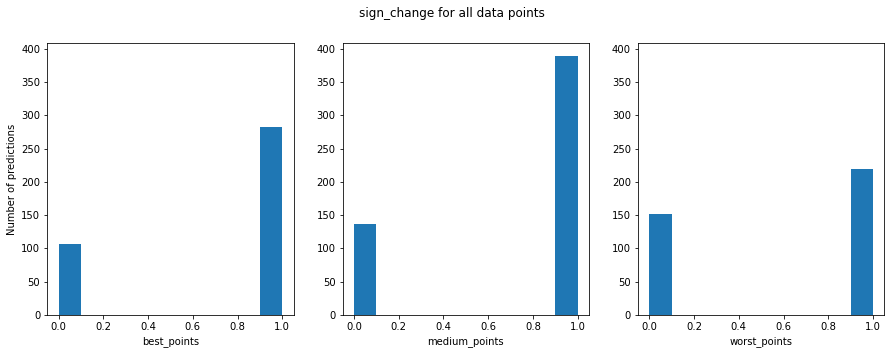

In [23]:
# Plotting date histogram
fig = plt.figure(figsize=(15,5))
fig.suptitle("sign_change for all data points")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_points['sign_change'].values)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharey=ax1)
ax2.hist(medium_points['sign_change'].values)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharey=ax1)
ax3.hist(worst_points['sign_change'].values)
plt.xlabel("worst_points")

plt.show()

<li> We can see that the proportion of worst prediction points is more for negative change. </li>
<li> Hence model is able to detect positive change more efficiently when compared to negative chnage. </li>

### Conclusion and Oberservations

<li> With all the observations obatained with respect to both class labels, we can say that model has some strong areas of performance and also some wek areas. </li>
<li> With analysis of all the companies, with change prediction, AMZN is performing better while TSLA is performing worst. While in case of sign prediction, TSLA came out to be the better performing class label. </li>
<li> The prediction w.r.t. date is not varying much with both class labels. </li>
<li> Also it was observed that model is not performing upto the mark for both class labels if combined tweet text length value is higher beyond 8000. </li>
<li> Also, the % change value label value should be low for a good performance since there are very lesser values with high %change values hence model do not get enough data points in that region to train. </li>
<li> Also when compared to positive sign change labels(sign_change=1), there are are very few negative change values(sign_change=0). Hence, there is an imbalance in data but the imabalance is not present with %closing price change except for few high values.</li>
<li> Hence while handling imbalance in sign_change label a single model might not be sufficient to predict all the aspects of this price change prediction. </li>